## Setup

In [9]:
import networkx as nx
import cassiopeia as cas
import pandas as pd
import pickle as pic
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Base parameters, no fitness
in_folder = "/data/yosef2/users/richardz/projects/CassiopeiaV2-Reproducibility/trees/exponential_plus_c/400cells/no_fit/char40/"
out_folder = "./benchmarking/"

In [ ]:
# directory management


In [2]:
# Getting ground truth tree metrics for ONE tree
i = 3
ground_truth_filepath = in_folder + "tree" + str(i) + ".pkl"
tree = pic.load(open("/home/eecs/ivalexander13/datadir/simulation_data/trees/mutrate1/char10/states50/exponential_plus_c/cells2000/no_fit/tree1.pkl", "rb"))

tree.character_matrix = tree.character_matrix.replace(-2, -1) 
tree.character_matrix.values

array([[28, 32, 25, ...,  2, 43, 18],
       [28, 32, 25, ...,  2, 43, 18],
       [28, 32, 25, ...,  2, 43, 18],
       ...,
       [28, 32, 25, ...,  2, 43, 18],
       [28, 32, 25, ...,  2, 43, 18],
       [28, 32, 25, ...,  2, 43, 18]])

In [ ]:
import numba, scipy

In [205]:
def logdet(
    s1,
    s2,
    missing_state_indicator=-1,
    weights = None,
) -> float:
    max_val: int = np.max([*s1, *s2])
    out = np.zeros([max_val+1]*2)
    for r, c in zip(s1, s2):
        if r == missing_state_indicator or c == missing_state_indicator:
            continue
        out[r, c] += 1
    out = out / np.max(out)
    eigs = scipy.linalg.svd(out, compute_uv=False, check_finite=False)
    eigs = np.log(eigs[eigs != 0])[:10]
    logdet_hat = -np.sum(eigs)
    
    return logdet_hat
logdet(tree.character_matrix.values[1], tree.character_matrix.values[20])

9.41014961595198

In [206]:
import itertools
out = np.zeros([tree.character_matrix.shape[0]]*2)
for r, c in itertools.combinations(range(tree.character_matrix.shape[0]), 2):
    if r > 2: break
    score = logdet(tree.character_matrix.values[c], tree.character_matrix.values[r])
    out[r, c] = out[c, r] = score
    
dissim = pd.DataFrame(out, columns=tree.character_matrix.index, index=tree.character_matrix.index)

In [3]:
# PARAM: Get computed dissimilarity matrix.
tree.compute_dissimilarity_map(dissimilarity_function=cas.solver.dissimilarity_functions.hamming_similarity_normalized_over_missing)
dissim = tree.get_dissimilarity_map()

In [4]:
# get true distances
dists = pd.DataFrame(columns=tree.leaves, index=tree.leaves)
for leaf in tree.leaves:
    dists[leaf] = tree.get_distances(leaf, leaves_only=True).values() # assume sorted

In [5]:
# PARAM: Get computed dissimilarity matrix.
tree.set_dissimilarity_map(dists)

In [20]:
def melt_triu(dataf):
    return np.fliplr(dataf.values)[np.triu_indices_from(dataf)]

dissim_melt = melt_triu(tree.get_dissimilarity_map())
dist_melt = melt_triu(dists)

In [21]:
mse = (np.square(dissim_melt - dist_melt)).mean(axis=None)
mse

0.0

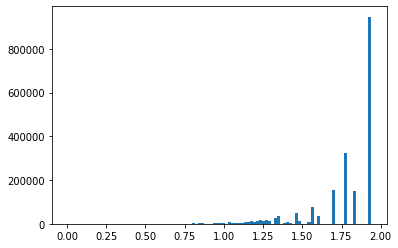

In [22]:
plt.hist(dissim_melt[dissim_melt >-1], bins=100);

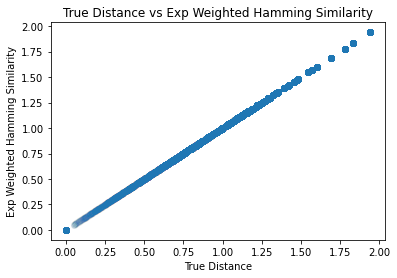

In [23]:
import matplotlib.pyplot as plt
plt.scatter(x=dist_melt, y=dissim_melt, alpha=0.01);
plt.title('True Distance vs Exp Weighted Hamming Similarity')
plt.xlabel('True Distance')
plt.ylabel('Exp Weighted Hamming Similarity')
linx = np.linspace(0, max(*dist_melt, *dissim_melt))
# plt.plot(linx, -linx, 'red', alpha=0.3)
plt.show();

Linear Coef: 1.0000000000019271


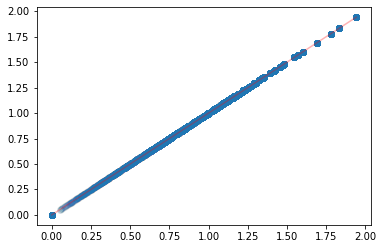

In [24]:
#get the correlation
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(dissim_melt.reshape(-1, 1), dist_melt)
plt.scatter(x=reg.predict(dissim_melt.reshape(-1, 1)), y=dist_melt, alpha=0.01);
linx = np.linspace(0, max(*dist_melt, *dissim_melt))
plt.plot(linx, linx, 'red', alpha=0.3)
print(f"Linear Coef: {reg.coef_[0]}")

In [13]:
# Try plotting |dist - dissim|

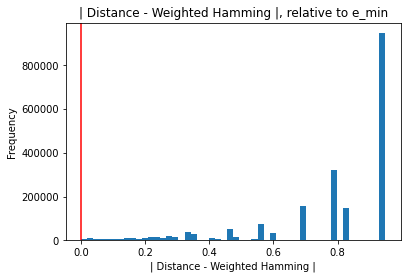

In [14]:
plt.hist(abs(dissim_melt - dist_melt), bins=50);

# find e_min
alldists = np.array(list(tree.get_distances(leaf, leaves_only=True).values()))
alldists = alldists[alldists != 0]
emin = min(alldists)

plt.axvline(x=emin / 2, c='red')
plt.title('| Distance - Weighted Hamming |, relative to e_min')
plt.ylabel('Frequency')
plt.xlabel('| Distance - Weighted Hamming |')
plt.show();

In [15]:
# Calculate Correlation
np.corrcoef(dissim_melt, dist_melt)[0, 1]

0.1519086871228774